In [9]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
from tqdm import tqdm
import cv2
import traceback

# --------- helpers ---------
def load_ac_csv(csv_path):
    df = pd.read_csv(csv_path)
    if "uuid" not in df.columns:
        raise ValueError("CSV must contain a 'uuid' column")
    return df.set_index("uuid")

def get_reference_ac(ac_df, uuid, strategy="first"):
    try:
        row = ac_df.loc[uuid]
    except KeyError:
        print(f"⚠️ Missing AC row for {uuid}")
        return None
    vals = row.filter(like="sweep_").dropna().values.astype(float)
    if len(vals) == 0:
        return None
    if strategy == "first":
        return float(vals[0])
    if strategy == "mean":
        return float(vals.mean())
    if strategy == "max":
        return float(vals.max())
    raise ValueError("strategy must be first|mean|max")

def get_frame_labels_from_mask(mask_np):
    # 0=empty, 1=optimal (label==1), 2=suboptimal (label==2)
    labels = []
    for fr in mask_np:
        if (fr == 1).any():
            labels.append(1)
        elif (fr == 2).any():
            labels.append(2)
        else:
            labels.append(0)
    return np.array(labels, dtype=np.uint8)

def percentile_scale_to_uint8(vol, lo=1, hi=99):
    # vol: [T,H,W] float32
    lo_v, hi_v = np.percentile(vol, [lo, hi])
    vol = (vol - lo_v) / (hi_v - lo_v + 1e-6)
    vol = np.clip(vol, 0, 1)
    return (vol * 255.0).astype(np.uint8)

def resize_stack(arr, size, interp):
    # arr: [T,H,W], returns [T,h,w]
    h, w = size
    return np.stack([cv2.resize(fr, (w, h), interpolation=interp) for fr in arr], axis=0)

def pack_mask_two_planes(mask_small):
    """
    For masks with values in {0,1,2}, store two packed bitplanes:
      plane1: (==1), plane2: (==2)
    Returns dict with shapes to reconstruct later if needed.
    """
    m1 = (mask_small == 1)
    m2 = (mask_small == 2)
    packed1 = np.packbits(m1, axis=-1)  # pack bits along width
    packed2 = np.packbits(m2, axis=-1)
    return {
        "mask_shape": np.array(mask_small.shape, dtype=np.int32),
        "mask_p1": packed1,
        "mask_p2": packed2,
    }

# --------- converter ---------
def convert_acouslic_dataset_npz_small(
    image_dir,
    mask_dir,
    csv_path,
    output_dir,
    limit=None,
    pixel_spacing=0.28,
    target_size=(281, 372),      # (H, W)
    keep_mask=False,             # set True if you really need masks
    pack_masks=True,             # if keeping masks, store packed bitplanes
    scale_lo=1, scale_hi=99      # robust scaling percentiles
):
    os.makedirs(output_dir, exist_ok=True)
    ac_df = load_ac_csv(csv_path)

    files = sorted([f for f in os.listdir(image_dir) if f.endswith(".mha")])
    converted = 0

    for f in tqdm(files, desc="Converting ACOUSLIC -> NPZ (compact)"):
        if limit is not None and converted >= limit:
            break

        case_id = f[:-4]
        uuid = case_id
        img_path = os.path.join(image_dir, f)
        msk_path = os.path.join(mask_dir,  f)
        out_path = os.path.join(output_dir, case_id + ".npz")

        if os.path.exists(out_path):
            print(f"ℹ️ Skipping {case_id}: already exists.")
            continue

        try:
            # Load MHA
            img = sitk.ReadImage(img_path)
            msk = sitk.ReadImage(msk_path)
            img_np = sitk.GetArrayFromImage(img).astype(np.float32)   # [T,H,W]
            msk_np = sitk.GetArrayFromImage(msk).astype(np.uint8)     # [T,H,W]

            if img_np.shape != msk_np.shape:
                print(f"⚠️ Shape mismatch {case_id}: {img_np.shape} vs {msk_np.shape}")
                continue

            # Downsample (anti-aliased for images, nearest for masks)
            new_h, new_w = target_size
            img_small = resize_stack(img_np, (new_h, new_w), cv2.INTER_AREA)
            msk_small = resize_stack(msk_np, (new_h, new_w), cv2.INTER_NEAREST)

            # Robust scale images to uint8
            img_u8 = percentile_scale_to_uint8(img_small, lo=scale_lo, hi=scale_hi)  # [T,h,w], uint8

            # Per-frame labels from mask (keep for classification)
            labels = get_frame_labels_from_mask(msk_small)  # [T], uint8

            # AC reference
            ac_mm = get_reference_ac(ac_df, uuid, strategy="first")
            if ac_mm is None:
                print(f"⚠️ Missing AC for {uuid}, skipping.")
                continue

            # Build np.savez_compressed payload
            save_kwargs = dict(
                image=img_u8,                                # uint8
                label=labels,                                # uint8
                pixel_spacing=np.float32(pixel_spacing),
                ac_reference=np.float32(ac_mm),
                uuid=np.array(uuid),
                target_h=np.int32(new_h),
                target_w=np.int32(new_w),
                scale_lo=np.float32(scale_lo),
                scale_hi=np.float32(scale_hi),
            )

            if keep_mask:
                if pack_masks:
                    packed = pack_mask_two_planes(msk_small)
                    save_kwargs.update(packed)
                else:
                    save_kwargs["mask"] = msk_small.astype(np.uint8)

            # Save
            np.savez_compressed(out_path, **save_kwargs)

            size_mb = os.path.getsize(out_path)/1024/1024
            print(f"✅ {case_id} | AC={ac_mm:.2f} | T={img_u8.shape[0]} | size={size_mb:.1f} MB | labels={np.unique(labels)}")
            converted += 1

        except Exception as e:
            print(f"❌ Error {case_id}: {e}")
            traceback.print_exc()


In [10]:
convert_acouslic_dataset_npz_small(
    image_dir="D:/dataset/acouslic-ai-train-set/images/stacked_fetal_ultrasound",
    mask_dir="D:/dataset/acouslic-ai-train-set/masks/stacked_fetal_abdomen",
    csv_path="D:/dataset/acouslic-ai-train-set/circumferences/fetal_abdominal_circumferences_per_sweep.csv",
    output_dir="D:/dataset/converted_classifier_npz_compact",
    limit=300,
    target_size=(281, 372),
    keep_mask=False,     # True only if you need masks later
    pack_masks=True
)


Converting ACOUSLIC -> NPZ (compact):   0%|          | 0/300 [00:00<?, ?it/s]

ℹ️ Skipping 0199616b-bdeb-4119-97a3-a5a3571bd641: already exists.
ℹ️ Skipping 02d3a9bc-63e2-4deb-9dc1-dba17e7d54c1: already exists.
ℹ️ Skipping 02ee26a5-a665-4531-bec1-8bac83345a94: already exists.
ℹ️ Skipping 032b9024-3685-4a81-a62e-813d2da3d387: already exists.
ℹ️ Skipping 0428da3d-fef4-4c9b-96f2-5ffedaee82d0: already exists.
ℹ️ Skipping 046ed03e-4b35-4519-bb5f-cd4b0474a060: already exists.
ℹ️ Skipping 04a04f2e-840b-47f8-a907-abe7aeab3f41: already exists.
ℹ️ Skipping 04ef1176-7d54-4942-899d-f0fa69ad34bb: already exists.
ℹ️ Skipping 056764b4-7c0c-4452-832d-3d1cbb5a0464: already exists.
ℹ️ Skipping 05f72776-bf41-40ea-bdea-a7bcfa1eb9ba: already exists.


Converting ACOUSLIC -> NPZ (compact):   4%|▎         | 11/300 [00:03<01:36,  3.01it/s]

✅ 0607eff0-2268-46b6-8fb8-16e40a521a42 | AC=247.48 | T=840 | size=40.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):   4%|▍         | 12/300 [00:07<03:20,  1.44it/s]

✅ 0658cdf9-53bc-46a9-ae86-cc99a6fc5e77 | AC=280.98 | T=840 | size=39.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):   4%|▍         | 13/300 [00:10<05:00,  1.05s/it]

✅ 0685cfaf-d585-40b3-a365-52f70f2536b6 | AC=221.46 | T=840 | size=42.0 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):   5%|▍         | 14/300 [00:13<06:41,  1.40s/it]

✅ 069c0349-1e8d-42d0-afa1-69c7114a742f | AC=219.28 | T=840 | size=38.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):   5%|▌         | 15/300 [00:16<08:15,  1.74s/it]

✅ 071ee12c-a8a5-45fd-b191-fd5ec3b00766 | AC=206.22 | T=840 | size=38.9 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):   5%|▌         | 16/300 [00:19<09:45,  2.06s/it]

✅ 09ddeecb-72e0-417a-85fd-77d397f6219d | AC=209.12 | T=840 | size=38.9 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):   6%|▌         | 17/300 [00:23<10:58,  2.33s/it]

✅ 0d0a3298-a9c6-43c3-a9e3-df3a9c0afa06 | AC=186.31 | T=840 | size=36.9 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):   6%|▌         | 18/300 [00:26<12:07,  2.58s/it]

✅ 0d7c4d8f-6e07-4f2b-aa76-8915ce15a38f | AC=230.29 | T=840 | size=45.3 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):   6%|▋         | 19/300 [00:29<12:52,  2.75s/it]

✅ 0e2631b6-ed14-4ce4-bc17-896590c406fd | AC=301.35 | T=840 | size=38.9 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):   7%|▋         | 20/300 [00:32<13:21,  2.86s/it]

✅ 0f32e98f-8257-4649-a8a2-3cccb2c1a2e5 | AC=217.27 | T=840 | size=38.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):   7%|▋         | 21/300 [00:35<13:39,  2.94s/it]

✅ 1269a6c4-7f04-4927-9308-e4fd68883906 | AC=205.53 | T=840 | size=37.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):   7%|▋         | 22/300 [00:39<13:57,  3.01s/it]

✅ 12941223-b27c-47f5-bcb0-7f7bfba18bba | AC=242.83 | T=840 | size=38.3 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):   8%|▊         | 23/300 [00:42<14:09,  3.07s/it]

✅ 136db39d-90e4-4702-aee7-dc5cd3169268 | AC=274.25 | T=840 | size=37.3 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):   8%|▊         | 24/300 [00:45<14:24,  3.13s/it]

✅ 1613944c-ea48-4953-84e9-953b9d86f175 | AC=305.36 | T=840 | size=40.8 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):   8%|▊         | 25/300 [00:48<14:34,  3.18s/it]

✅ 177786dd-a8f4-4d57-ac1b-13811480bd09 | AC=218.81 | T=840 | size=45.9 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):   9%|▊         | 26/300 [00:52<14:30,  3.18s/it]

✅ 17b31515-75fb-41fc-8908-7c0264d21204 | AC=295.23 | T=840 | size=38.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):   9%|▉         | 27/300 [00:55<14:24,  3.17s/it]

✅ 19202c0a-fade-4c7a-9878-e91d823963d6 | AC=201.37 | T=840 | size=36.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):   9%|▉         | 28/300 [00:58<14:29,  3.20s/it]

✅ 1a998ef3-797f-4a17-9aa6-96cfb9af87c9 | AC=255.24 | T=840 | size=36.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  10%|▉         | 29/300 [01:01<14:21,  3.18s/it]

✅ 1af7894a-9f0a-41e8-9c10-a11c0341a93e | AC=229.54 | T=840 | size=37.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  10%|█         | 30/300 [01:04<14:22,  3.19s/it]

✅ 1b250c39-7217-4921-838b-ed2681ebfef2 | AC=180.21 | T=840 | size=43.8 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  10%|█         | 31/300 [01:08<14:22,  3.21s/it]

✅ 1b3db504-c1fe-45f0-96dc-3cfb851d5bca | AC=246.67 | T=840 | size=40.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  11%|█         | 32/300 [01:11<14:56,  3.34s/it]

✅ 1c1a1114-3e30-436b-b656-101e6050ea32 | AC=247.16 | T=840 | size=45.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  11%|█         | 33/300 [01:15<14:59,  3.37s/it]

✅ 1cd004a2-94fb-429a-9e14-fc950bbd8852 | AC=226.02 | T=840 | size=40.2 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  11%|█▏        | 34/300 [01:18<14:58,  3.38s/it]

✅ 1d25be5c-d4ba-48bf-afd4-a133581f8491 | AC=284.74 | T=840 | size=40.7 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  12%|█▏        | 35/300 [01:21<14:55,  3.38s/it]

✅ 1d479820-767b-4d0f-b6cf-12ec5d3a26e7 | AC=226.86 | T=840 | size=38.3 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  12%|█▏        | 36/300 [01:25<15:01,  3.42s/it]

✅ 1dab0e37-e5e4-41d4-b132-32103b385c78 | AC=295.79 | T=840 | size=33.1 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  12%|█▏        | 37/300 [01:28<15:05,  3.44s/it]

✅ 1dc4fda1-c351-4f4f-8df8-9bb35eb46062 | AC=287.21 | T=840 | size=43.9 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  13%|█▎        | 38/300 [01:32<15:07,  3.46s/it]

✅ 1dccf454-18df-4bfb-b7bf-92acbea3d8e1 | AC=182.66 | T=840 | size=35.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  13%|█▎        | 39/300 [01:35<15:01,  3.46s/it]

✅ 1e927a7e-90cd-475b-848d-6dc6368f42ca | AC=185.57 | T=840 | size=39.6 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  13%|█▎        | 40/300 [01:39<14:36,  3.37s/it]

✅ 1f002210-be79-4c02-b948-7c27c5fd2f1e | AC=284.11 | T=840 | size=38.5 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  14%|█▎        | 41/300 [01:42<14:31,  3.36s/it]

✅ 1ff3221d-43d3-4065-9393-347f2d0edac0 | AC=258.48 | T=840 | size=45.2 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  14%|█▍        | 42/300 [01:45<14:08,  3.29s/it]

✅ 20a2b2a1-c91e-4ee0-93b6-c0d8fe2212db | AC=230.53 | T=840 | size=37.3 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  14%|█▍        | 43/300 [01:48<14:11,  3.31s/it]

✅ 21127c13-cd7f-456b-ad07-71531d1cb054 | AC=151.73 | T=840 | size=37.5 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  15%|█▍        | 44/300 [01:52<13:52,  3.25s/it]

✅ 21883c54-c2ac-4bc3-b557-aa6d41d51087 | AC=168.82 | T=840 | size=40.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  15%|█▌        | 45/300 [01:55<14:08,  3.33s/it]

✅ 21e6dac4-7606-4abb-9284-d5d9bd0d2b6e | AC=156.78 | T=840 | size=41.1 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  15%|█▌        | 46/300 [01:58<14:08,  3.34s/it]

✅ 21ef25cf-842d-4adf-be9a-d07e2e259855 | AC=195.24 | T=840 | size=40.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  16%|█▌        | 47/300 [02:02<14:04,  3.34s/it]

✅ 229525cd-637a-4560-ad44-45b6f04a5d1f | AC=203.97 | T=840 | size=33.9 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  16%|█▌        | 48/300 [02:05<14:17,  3.40s/it]

✅ 23d90415-7355-4677-83aa-a214f6b17c03 | AC=229.59 | T=840 | size=45.9 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  16%|█▋        | 49/300 [02:09<14:07,  3.38s/it]

✅ 245dbf25-055e-4dba-8dfb-18cb27b4a880 | AC=205.05 | T=840 | size=39.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  17%|█▋        | 50/300 [02:12<14:11,  3.41s/it]

✅ 246c5909-ac94-47b1-b343-cb358939e359 | AC=312.03 | T=840 | size=39.3 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  17%|█▋        | 51/300 [02:16<14:14,  3.43s/it]

✅ 2594b3cd-e3c2-482d-879b-642f9cdb339d | AC=287.89 | T=840 | size=39.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  17%|█▋        | 52/300 [02:19<14:16,  3.45s/it]

✅ 2697b349-9abe-4ec3-bb42-96ea329418eb | AC=204.15 | T=840 | size=47.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  18%|█▊        | 53/300 [02:22<14:07,  3.43s/it]

✅ 28c99f94-69b1-4e19-95de-2fc228c419cf | AC=167.23 | T=840 | size=39.3 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  18%|█▊        | 54/300 [02:26<14:05,  3.44s/it]

✅ 2a2817fe-e4d8-4fe6-a530-7456c3648c01 | AC=252.57 | T=840 | size=36.7 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  18%|█▊        | 55/300 [02:29<14:03,  3.44s/it]

✅ 2b1767d0-ce44-4093-8713-9b9ca2823ec7 | AC=288.27 | T=840 | size=42.5 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  19%|█▊        | 56/300 [02:33<13:59,  3.44s/it]

✅ 2b832993-22e9-4393-a9fe-9296864495ea | AC=295.69 | T=840 | size=38.5 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  19%|█▉        | 57/300 [02:36<13:49,  3.42s/it]

✅ 2c979adb-f7ee-4775-86d8-66ca4169884a | AC=239.38 | T=840 | size=38.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  19%|█▉        | 58/300 [02:39<13:24,  3.32s/it]

✅ 2c9934e1-ec1a-49ea-b24f-ff62de1965d1 | AC=208.60 | T=840 | size=38.5 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  20%|█▉        | 59/300 [02:42<13:14,  3.30s/it]

✅ 2cf6450c-a57e-41a8-8918-74218df6e9bf | AC=247.28 | T=840 | size=44.2 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  20%|██        | 60/300 [02:46<13:04,  3.27s/it]

✅ 2cf8bcb5-3570-474b-a7bc-d86d9c037e08 | AC=156.42 | T=840 | size=37.1 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  20%|██        | 61/300 [02:49<12:47,  3.21s/it]

✅ 2dccc77d-0963-4199-8501-04925b3de876 | AC=190.01 | T=840 | size=39.7 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  21%|██        | 62/300 [02:52<12:41,  3.20s/it]

✅ 2de0ce54-f9ef-49ec-b4b8-59f304656111 | AC=274.93 | T=840 | size=35.5 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  21%|██        | 63/300 [02:56<13:07,  3.32s/it]

✅ 2e99ee0e-506a-443b-8c16-e8a0619da2f7 | AC=289.61 | T=840 | size=43.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  21%|██▏       | 64/300 [02:59<13:17,  3.38s/it]

✅ 2fe70922-1d3a-4ce7-b8ad-55a0c07efe74 | AC=184.07 | T=840 | size=40.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  22%|██▏       | 65/300 [03:03<13:21,  3.41s/it]

✅ 300602fc-058e-456b-b872-8e9573428309 | AC=266.24 | T=840 | size=37.8 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  22%|██▏       | 66/300 [03:06<13:14,  3.40s/it]

✅ 30555893-2ac6-45c9-b404-8ca2d9f90b05 | AC=234.23 | T=840 | size=33.7 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  22%|██▏       | 67/300 [03:09<13:04,  3.37s/it]

✅ 30d9ee24-7603-46c5-9d05-7d8a6d6a292e | AC=180.84 | T=840 | size=37.9 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  23%|██▎       | 68/300 [03:13<13:03,  3.38s/it]

✅ 33397b96-5fad-441e-9b64-ff3bd5d0b2f9 | AC=193.03 | T=840 | size=41.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  23%|██▎       | 69/300 [03:16<13:03,  3.39s/it]

✅ 339c3f53-eaa7-4660-a2bb-b9e1726cd079 | AC=203.82 | T=840 | size=35.8 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  23%|██▎       | 70/300 [03:20<13:10,  3.44s/it]

✅ 3479bfa3-6c07-462b-ab3d-409026598f0f | AC=350.57 | T=840 | size=41.2 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  24%|██▎       | 71/300 [03:23<13:10,  3.45s/it]

✅ 356d0021-3560-421a-96f4-ecffd4eb6005 | AC=171.46 | T=840 | size=42.2 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  24%|██▍       | 72/300 [03:27<13:11,  3.47s/it]

✅ 36bcc878-7cf1-494c-a67d-7520145cdde2 | AC=270.52 | T=840 | size=38.2 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  24%|██▍       | 73/300 [03:30<13:01,  3.44s/it]

✅ 36d10668-e159-4c9d-811e-b066f4872bda | AC=222.29 | T=840 | size=36.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  25%|██▍       | 74/300 [03:33<12:52,  3.42s/it]

✅ 379f256a-879c-4e1d-9b30-a0e9ee51e098 | AC=250.53 | T=840 | size=39.1 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  25%|██▌       | 75/300 [03:37<12:49,  3.42s/it]

✅ 3825d340-86df-41a7-b415-8c880818ca8e | AC=231.23 | T=840 | size=38.1 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  25%|██▌       | 76/300 [03:40<12:39,  3.39s/it]

✅ 3b3218ac-3616-4aaf-b0ae-b7287803a298 | AC=240.21 | T=840 | size=39.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  26%|██▌       | 77/300 [03:44<12:47,  3.44s/it]

✅ 3bd64075-6e7e-463d-86e1-19071f04327c | AC=210.79 | T=840 | size=43.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  26%|██▌       | 78/300 [03:47<12:40,  3.43s/it]

✅ 3d221d3e-749e-4b06-ac7a-762c3fc4c88a | AC=269.90 | T=840 | size=36.5 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  26%|██▋       | 79/300 [03:50<12:41,  3.45s/it]

✅ 3d24bef2-3cfa-439f-b74f-6ae1e404ab06 | AC=213.32 | T=840 | size=44.6 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  27%|██▋       | 80/300 [03:54<12:33,  3.43s/it]

✅ 3d902e8c-626f-46b6-8942-243b3270d929 | AC=179.22 | T=840 | size=39.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  27%|██▋       | 81/300 [03:57<12:38,  3.46s/it]

✅ 3d9ebba3-0eff-4e57-8641-7099ba774574 | AC=200.01 | T=840 | size=44.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  27%|██▋       | 82/300 [04:01<12:35,  3.47s/it]

✅ 3daf4e87-136f-4644-9ec7-35d4de3650c9 | AC=274.61 | T=840 | size=35.5 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  28%|██▊       | 83/300 [04:04<12:24,  3.43s/it]

✅ 3e42e61f-a6ec-47ae-bbb7-e84b47170a5f | AC=288.30 | T=840 | size=37.3 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  28%|██▊       | 84/300 [04:08<12:24,  3.45s/it]

✅ 40d97ff5-0d2f-4d9c-a6bc-8d07713a86c2 | AC=282.49 | T=840 | size=36.9 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  28%|██▊       | 85/300 [04:11<12:16,  3.43s/it]

✅ 42950f64-500a-46a8-9957-ea690a8292a4 | AC=274.22 | T=840 | size=40.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  29%|██▊       | 86/300 [04:15<12:13,  3.43s/it]

✅ 43ccd4c5-0644-402c-8220-d1c04cfc34ec | AC=270.52 | T=840 | size=40.3 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  29%|██▉       | 87/300 [04:18<12:01,  3.39s/it]

✅ 43f564f8-6772-4341-9083-128fd6eed4c9 | AC=158.61 | T=840 | size=39.2 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  29%|██▉       | 88/300 [04:21<11:59,  3.39s/it]

✅ 4454a0d6-325b-442b-b07a-54f26b52c0b2 | AC=182.99 | T=840 | size=37.2 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  30%|██▉       | 89/300 [04:24<11:38,  3.31s/it]

✅ 44b70504-4e9e-4e02-b13f-6c33808dd7f9 | AC=225.76 | T=840 | size=38.2 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  30%|███       | 90/300 [04:28<11:31,  3.29s/it]

✅ 4670a2b3-cad0-4d23-afaa-e823438f6944 | AC=230.32 | T=840 | size=44.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  30%|███       | 91/300 [04:31<11:39,  3.35s/it]

✅ 47540baa-7ab8-425a-9e77-8005cb1c02f4 | AC=312.66 | T=840 | size=37.2 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  31%|███       | 92/300 [04:34<11:35,  3.34s/it]

✅ 477c0589-f74a-4ecf-8b22-a27776fcbffe | AC=305.03 | T=840 | size=35.1 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  31%|███       | 93/300 [04:38<11:36,  3.37s/it]

✅ 484c03b0-441d-4966-b10e-06b31d84e55e | AC=307.46 | T=840 | size=36.8 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  31%|███▏      | 94/300 [04:41<11:42,  3.41s/it]

✅ 489efa27-f374-4d48-a251-dd2e4d1b09aa | AC=344.00 | T=840 | size=34.6 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  32%|███▏      | 95/300 [04:45<11:38,  3.41s/it]

✅ 4908826a-f3f0-4357-8c8e-8b3d8e6d48c4 | AC=253.57 | T=840 | size=38.4 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  32%|███▏      | 96/300 [04:48<11:36,  3.41s/it]

✅ 4abd109b-71ff-4403-95a9-9a7d3592bf5f | AC=240.60 | T=840 | size=38.9 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  32%|███▏      | 97/300 [04:52<11:37,  3.44s/it]

✅ 4acfbc25-cf86-49c1-bb77-689f40db4d34 | AC=226.50 | T=840 | size=41.3 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  33%|███▎      | 98/300 [04:55<11:19,  3.36s/it]

✅ 4adc2ad8-f29d-41e3-9bf6-cc935057ff71 | AC=287.73 | T=840 | size=36.3 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  33%|███▎      | 99/300 [04:58<11:02,  3.30s/it]

✅ 4b6b2a4e-8ad8-4f29-ad47-dad67dfccb6c | AC=285.15 | T=840 | size=42.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  33%|███▎      | 100/300 [05:01<10:46,  3.23s/it]

✅ 4bf11a9a-cb81-4dd4-91d4-5f6a59deb47d | AC=183.54 | T=840 | size=38.8 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  34%|███▎      | 101/300 [05:05<10:54,  3.29s/it]

✅ 4d1f4689-55ad-4b3d-bc3f-c43e66e0b92d | AC=278.57 | T=840 | size=37.9 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  34%|███▍      | 102/300 [05:08<11:02,  3.35s/it]

✅ 4d4db621-e017-4c4b-a23d-62ddfa40a5d8 | AC=220.87 | T=840 | size=45.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  34%|███▍      | 103/300 [05:12<11:12,  3.41s/it]

✅ 4eebb2cd-df34-4bbb-871d-f37ed26a0204 | AC=180.91 | T=840 | size=45.3 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  35%|███▍      | 104/300 [05:15<11:06,  3.40s/it]

✅ 4fc1cf8c-52cf-444d-a1fb-6b85c47694b2 | AC=252.69 | T=840 | size=36.2 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  35%|███▌      | 105/300 [05:18<11:11,  3.44s/it]

✅ 502bfdba-4bb0-4c68-bd25-a7d2d7b1124e | AC=227.02 | T=840 | size=38.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  35%|███▌      | 106/300 [05:22<11:22,  3.52s/it]

✅ 50fb5627-fea3-4126-8082-a88aa5590b51 | AC=268.90 | T=840 | size=44.0 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  36%|███▌      | 107/300 [05:26<11:14,  3.49s/it]

✅ 53056b82-e84c-404a-8d3d-29c1d24d94c8 | AC=268.86 | T=840 | size=38.4 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  36%|███▌      | 108/300 [05:29<11:04,  3.46s/it]

✅ 5320a755-d8e5-403d-9769-6d9fe9b598df | AC=211.18 | T=840 | size=35.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  36%|███▋      | 109/300 [05:32<10:53,  3.42s/it]

✅ 537243c9-0bbe-4295-aea0-4c29316e1efb | AC=269.19 | T=840 | size=37.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  37%|███▋      | 110/300 [05:36<10:47,  3.41s/it]

✅ 540607e9-2186-4213-9290-b6bbd655c846 | AC=261.81 | T=840 | size=39.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  37%|███▋      | 111/300 [05:39<10:40,  3.39s/it]

✅ 54305199-c82c-4b90-b4a1-2b166ef7bab5 | AC=285.81 | T=840 | size=39.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  37%|███▋      | 112/300 [05:42<10:37,  3.39s/it]

✅ 5568cf99-11f7-4641-abd5-9579405c0eb3 | AC=273.68 | T=840 | size=40.3 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  38%|███▊      | 113/300 [05:46<10:41,  3.43s/it]

✅ 55eff0af-e8a1-4afa-965d-fff5a69e7399 | AC=278.18 | T=840 | size=44.2 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  38%|███▊      | 114/300 [05:49<10:43,  3.46s/it]

✅ 585178ca-483e-45fa-9c89-2dbd51ebb69e | AC=282.47 | T=840 | size=42.7 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  38%|███▊      | 115/300 [05:53<10:38,  3.45s/it]

✅ 58e919b6-12d7-4c32-86b4-adca239e7a85 | AC=200.80 | T=840 | size=40.5 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  39%|███▊      | 116/300 [05:56<10:33,  3.44s/it]

✅ 5bdd3202-3eac-417c-856b-c642ee0aabdf | AC=271.92 | T=840 | size=39.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  39%|███▉      | 117/300 [06:00<10:30,  3.45s/it]

✅ 5be4a966-5b05-473a-8118-9557c95dea4d | AC=293.09 | T=840 | size=42.5 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  39%|███▉      | 118/300 [06:03<10:26,  3.44s/it]

✅ 5c46829f-7584-4ff9-9e76-7f72eb8ae78f | AC=221.85 | T=840 | size=39.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  40%|███▉      | 119/300 [06:07<10:23,  3.44s/it]

✅ 5d0e2f3c-f494-48a7-942b-2c5942982aaf | AC=270.81 | T=840 | size=41.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  40%|████      | 120/300 [06:10<10:16,  3.42s/it]

✅ 5d8f1a4a-dc8a-402a-b8ac-64773efbd299 | AC=306.13 | T=840 | size=36.7 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  40%|████      | 121/300 [06:13<10:10,  3.41s/it]

✅ 5e4e59bc-8445-47e5-80f3-bf6256ee6ce3 | AC=247.36 | T=840 | size=38.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  41%|████      | 122/300 [06:17<10:11,  3.44s/it]

✅ 5f3d6529-2de6-472b-88b6-7b9dfbf225a9 | AC=338.04 | T=840 | size=37.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  41%|████      | 123/300 [06:20<10:06,  3.43s/it]

✅ 5f901dfd-0f6c-46a4-9670-b519fb6041c8 | AC=206.37 | T=840 | size=40.4 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  41%|████▏     | 124/300 [06:24<09:56,  3.39s/it]

✅ 600e0d45-94fc-495d-9936-dbbc93d41686 | AC=288.31 | T=840 | size=38.9 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  42%|████▏     | 125/300 [06:27<09:58,  3.42s/it]

✅ 607623df-dcd8-46c0-8379-b19979761584 | AC=275.08 | T=840 | size=40.4 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  42%|████▏     | 126/300 [06:31<09:57,  3.44s/it]

✅ 622104f3-3bcb-47ba-be01-2f8fa2cd6aa8 | AC=222.15 | T=840 | size=42.5 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  42%|████▏     | 127/300 [06:34<09:55,  3.44s/it]

✅ 6379f8dd-b528-4a52-99ce-5d574936bc02 | AC=176.94 | T=840 | size=39.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  43%|████▎     | 128/300 [06:37<09:40,  3.38s/it]

✅ 63d1d72d-e6fc-46d9-912f-f3bd914f774d | AC=161.43 | T=840 | size=41.2 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  43%|████▎     | 129/300 [06:41<09:48,  3.44s/it]

✅ 6468fdf3-f005-4cfe-a400-679b3b246a49 | AC=303.12 | T=840 | size=46.2 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  43%|████▎     | 130/300 [06:44<09:42,  3.43s/it]

✅ 650d7789-6c25-47d5-9d8a-5294ace2f8ac | AC=155.41 | T=840 | size=41.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  44%|████▎     | 131/300 [06:48<09:39,  3.43s/it]

✅ 676c09f1-a666-4deb-877a-3ee06026523c | AC=174.80 | T=840 | size=38.3 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  44%|████▍     | 132/300 [06:51<09:49,  3.51s/it]

✅ 67d1dc32-1791-4595-937a-c51d4372c15c | AC=216.11 | T=840 | size=44.4 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  44%|████▍     | 133/300 [06:55<09:44,  3.50s/it]

✅ 685ebd4e-483d-4b2f-8e35-d05de68d0cd6 | AC=290.89 | T=840 | size=35.4 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  45%|████▍     | 134/300 [06:58<09:35,  3.46s/it]

✅ 6902b8ff-aa25-4dc7-892e-6ba6dabb3b0e | AC=162.72 | T=840 | size=35.8 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  45%|████▌     | 135/300 [07:01<09:10,  3.34s/it]

✅ 691a31e0-2910-49e3-8a1c-4b624cae3469 | AC=284.85 | T=840 | size=37.2 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  45%|████▌     | 136/300 [07:05<09:01,  3.30s/it]

✅ 69bca9da-204a-4d93-bacc-12919b720018 | AC=251.97 | T=840 | size=41.2 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  46%|████▌     | 137/300 [07:08<08:55,  3.29s/it]

✅ 6a235c9a-8844-46e8-8cde-cddb36960dc5 | AC=257.37 | T=840 | size=37.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  46%|████▌     | 138/300 [07:11<08:45,  3.24s/it]

✅ 6c1a6959-d923-49fc-856e-8af6ff0f43e3 | AC=292.21 | T=840 | size=34.4 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  46%|████▋     | 139/300 [07:14<08:50,  3.29s/it]

✅ 6d3158f9-6328-4975-8d8f-c2aaf84182ec | AC=234.26 | T=840 | size=40.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  47%|████▋     | 140/300 [07:18<08:51,  3.32s/it]

✅ 6ef0b571-c9e2-4ec4-855e-bfbae65daa08 | AC=200.11 | T=840 | size=35.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  47%|████▋     | 141/300 [07:21<08:56,  3.37s/it]

✅ 6f1930d7-49ca-4752-9d50-d26f7799dacc | AC=287.43 | T=840 | size=36.8 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  47%|████▋     | 142/300 [07:25<08:55,  3.39s/it]

✅ 6f3af20f-895c-4209-88a1-81b4ec0dcca6 | AC=282.45 | T=840 | size=43.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  48%|████▊     | 143/300 [07:28<09:04,  3.47s/it]

✅ 6fcb175f-52e4-4f3e-9956-f693b28f56e6 | AC=269.64 | T=840 | size=35.3 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  48%|████▊     | 144/300 [07:32<09:01,  3.47s/it]

✅ 70121050-3950-4eb1-ba24-efe37e9878e9 | AC=314.10 | T=840 | size=43.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  48%|████▊     | 145/300 [07:35<08:56,  3.46s/it]

✅ 7112c87c-fd2b-488e-bad7-f447f6b49caa | AC=251.87 | T=840 | size=37.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  49%|████▊     | 146/300 [07:39<08:56,  3.48s/it]

✅ 716640b1-bf3c-4cf5-8e2f-1e81152b6323 | AC=213.53 | T=840 | size=38.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  49%|████▉     | 147/300 [07:42<08:53,  3.49s/it]

✅ 71a82fd5-e8f8-4338-bfcb-e45cdf54d885 | AC=167.08 | T=840 | size=46.7 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  49%|████▉     | 148/300 [07:46<08:49,  3.49s/it]

✅ 72ffb0d0-13ce-456a-bb77-e34ad244f1b2 | AC=209.05 | T=840 | size=40.9 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  50%|████▉     | 149/300 [07:49<08:43,  3.47s/it]

✅ 738785d4-987a-415e-97b2-efd9c5618c67 | AC=181.76 | T=840 | size=38.0 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  50%|█████     | 150/300 [07:53<08:39,  3.46s/it]

✅ 740e57a6-d368-48d2-a3ec-fae51776757b | AC=181.20 | T=840 | size=43.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  50%|█████     | 151/300 [07:56<08:36,  3.47s/it]

✅ 74ddc9b8-9449-4cfa-8648-2131ecf9fd4a | AC=252.52 | T=840 | size=46.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  51%|█████     | 152/300 [07:59<08:29,  3.44s/it]

✅ 7603739a-a716-4785-bca1-db034fdfdb54 | AC=252.39 | T=840 | size=38.7 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  51%|█████     | 153/300 [08:03<08:28,  3.46s/it]

✅ 762a51e8-d1b6-4b8e-b1e4-8080b83392d5 | AC=169.32 | T=840 | size=41.5 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  51%|█████▏    | 154/300 [08:06<08:19,  3.42s/it]

✅ 775c0509-c874-4eca-8426-055db54f457e | AC=173.77 | T=840 | size=38.1 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  52%|█████▏    | 155/300 [08:10<08:13,  3.40s/it]

✅ 776b10a9-baa8-4c61-b096-bf8755b062e9 | AC=271.21 | T=840 | size=39.1 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  52%|█████▏    | 156/300 [08:13<08:11,  3.41s/it]

✅ 77b1166e-01d9-4b54-8793-288df6241e77 | AC=312.23 | T=840 | size=36.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  52%|█████▏    | 157/300 [08:17<08:09,  3.42s/it]

✅ 793bcf72-bcac-4d42-a726-66316996a6c5 | AC=249.59 | T=840 | size=38.9 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  53%|█████▎    | 158/300 [08:20<08:09,  3.45s/it]

✅ 7b06f498-6552-4d51-bf8a-11bb23b70a92 | AC=211.13 | T=840 | size=39.6 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  53%|█████▎    | 159/300 [08:23<08:04,  3.44s/it]

✅ 7b76359b-5d35-4b2b-868f-0988cce51784 | AC=187.04 | T=840 | size=39.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  53%|█████▎    | 160/300 [08:27<08:03,  3.45s/it]

✅ 7c7841fd-050e-4c32-8312-acad5968c6d7 | AC=278.42 | T=840 | size=41.9 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  54%|█████▎    | 161/300 [08:30<07:55,  3.42s/it]

✅ 7c98b80e-5a64-4973-9c2e-db2ee4b14736 | AC=159.93 | T=840 | size=38.9 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  54%|█████▍    | 162/300 [08:34<07:49,  3.40s/it]

✅ 7ce39b64-ca3f-4668-84b8-20ece5f4cc65 | AC=290.34 | T=840 | size=35.7 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  54%|█████▍    | 163/300 [08:37<07:51,  3.44s/it]

✅ 7d44ea4e-9079-4a4f-bd0e-2e27ff70e9ea | AC=300.39 | T=840 | size=43.2 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  55%|█████▍    | 164/300 [08:41<07:50,  3.46s/it]

✅ 7ee50b1f-a484-4ee1-8990-178a3b227369 | AC=257.88 | T=840 | size=40.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  55%|█████▌    | 165/300 [08:44<07:46,  3.46s/it]

✅ 7f689365-1782-4e41-b357-951d68cd3eee | AC=258.52 | T=840 | size=37.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  55%|█████▌    | 166/300 [08:48<07:39,  3.43s/it]

✅ 7f9d11c1-349b-4304-a672-4ed3f532d2f0 | AC=261.61 | T=840 | size=39.2 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  56%|█████▌    | 167/300 [08:51<07:37,  3.44s/it]

✅ 80bf8d64-ce5a-4c73-90b8-fe3261635be0 | AC=287.80 | T=840 | size=40.3 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  56%|█████▌    | 168/300 [08:54<07:34,  3.45s/it]

✅ 80fc531d-7187-4164-8798-b40ea16a2d2c | AC=185.21 | T=840 | size=42.5 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  56%|█████▋    | 169/300 [08:58<07:37,  3.49s/it]

✅ 81c96ebf-d425-4756-9919-1845ef0d88a5 | AC=205.67 | T=840 | size=45.2 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  57%|█████▋    | 170/300 [09:01<07:30,  3.47s/it]

✅ 82fe659c-d3cd-4f0b-a171-a3947209662b | AC=238.93 | T=840 | size=42.5 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  57%|█████▋    | 171/300 [09:05<07:27,  3.47s/it]

✅ 833c09d1-7257-45fc-9d41-76060614481f | AC=158.94 | T=840 | size=37.2 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  57%|█████▋    | 172/300 [09:08<07:22,  3.46s/it]

✅ 84cf6a52-fe8a-4cce-bcae-717f500c11c0 | AC=243.41 | T=840 | size=38.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  58%|█████▊    | 173/300 [09:12<07:17,  3.45s/it]

✅ 856cbf9c-8eb7-459c-b9e7-641459b393b0 | AC=252.40 | T=840 | size=40.5 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  58%|█████▊    | 174/300 [09:15<07:13,  3.44s/it]

✅ 85a90b54-9536-45ac-ac62-ced5f1a6f72d | AC=203.92 | T=840 | size=42.2 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  58%|█████▊    | 175/300 [09:19<07:11,  3.45s/it]

✅ 88224d16-3e42-4f10-9883-dbe1efeb6ae6 | AC=164.69 | T=840 | size=38.5 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  59%|█████▊    | 176/300 [09:22<06:57,  3.37s/it]

✅ 883501fc-2fcd-4fb4-b693-4d76df8a2ba4 | AC=252.46 | T=840 | size=36.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  59%|█████▉    | 177/300 [09:25<06:44,  3.29s/it]

✅ 89c3a8c0-1efe-4a7e-b921-c12f052cb2c0 | AC=170.96 | T=840 | size=35.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  59%|█████▉    | 178/300 [09:28<06:38,  3.26s/it]

✅ 8b80d5f7-3623-455a-8f37-7b92e6929bbb | AC=256.74 | T=840 | size=41.7 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  60%|█████▉    | 179/300 [09:31<06:28,  3.21s/it]

✅ 8ba63007-395c-4f8b-b5a0-a5f17596588a | AC=251.55 | T=840 | size=39.2 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  60%|██████    | 180/300 [09:34<06:26,  3.22s/it]

✅ 8ce68989-8856-4c3f-8988-4c9680b9a246 | AC=214.98 | T=840 | size=33.7 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  60%|██████    | 181/300 [09:38<06:25,  3.24s/it]

✅ 8daf5ef8-4a77-47dd-b1d8-d45caf83b64a | AC=206.26 | T=840 | size=46.7 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  61%|██████    | 182/300 [09:41<06:20,  3.22s/it]

✅ 8ec339fb-b01a-4034-9e39-feef178be78d | AC=236.19 | T=840 | size=37.9 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  61%|██████    | 183/300 [09:44<06:19,  3.25s/it]

✅ 8f50de4c-c82f-4210-8ba0-8edfe07fa017 | AC=223.47 | T=840 | size=45.6 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  61%|██████▏   | 184/300 [09:48<06:24,  3.32s/it]

✅ 90056737-5c36-4880-b11a-3b8d4bd84867 | AC=179.30 | T=840 | size=38.3 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  62%|██████▏   | 185/300 [09:51<06:32,  3.42s/it]

✅ 9062cf40-611e-4768-af8f-a6943d773afe | AC=246.85 | T=840 | size=34.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  62%|██████▏   | 186/300 [09:55<06:33,  3.45s/it]

✅ 924c5f09-2a22-4286-b478-c3e466f59425 | AC=220.96 | T=840 | size=38.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  62%|██████▏   | 187/300 [09:58<06:33,  3.48s/it]

✅ 9323ce9c-6523-428e-93a9-894f2203f1f0 | AC=240.57 | T=840 | size=37.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  63%|██████▎   | 188/300 [10:02<06:32,  3.51s/it]

✅ 93454ca6-86b9-4c7c-ae26-88c440bb056a | AC=244.87 | T=840 | size=41.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  63%|██████▎   | 189/300 [10:06<06:29,  3.51s/it]

✅ 938dda7a-321d-4ccc-ae3c-9276fe8a0e53 | AC=280.86 | T=840 | size=40.7 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  63%|██████▎   | 190/300 [10:09<06:28,  3.53s/it]

✅ 94e39208-2b04-4a1e-8f16-a830fc0fbaf1 | AC=310.40 | T=840 | size=45.9 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  64%|██████▎   | 191/300 [10:13<06:25,  3.53s/it]

✅ 95da2e16-5b4f-49cf-8c0f-86e3b7dff568 | AC=257.64 | T=840 | size=38.2 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  64%|██████▍   | 192/300 [10:16<06:19,  3.52s/it]

✅ 970b5275-ac9c-4844-abf5-d291becaf186 | AC=327.59 | T=840 | size=37.0 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  64%|██████▍   | 193/300 [10:20<06:13,  3.49s/it]

✅ 97363a66-8aec-4b52-8797-514e8c98205b | AC=180.13 | T=840 | size=39.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  65%|██████▍   | 194/300 [10:23<06:13,  3.52s/it]

✅ 97bec430-f17c-47bc-a138-a9bd69f3875a | AC=269.12 | T=840 | size=37.2 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  65%|██████▌   | 195/300 [10:27<06:07,  3.50s/it]

✅ 97cac2e6-4c2b-4a39-a602-0b01fa3ebc4c | AC=271.34 | T=840 | size=39.6 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  65%|██████▌   | 196/300 [10:30<06:02,  3.49s/it]

✅ 98b74af5-0f1c-4e9d-ad98-3161c3c51bf0 | AC=275.17 | T=840 | size=38.0 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  66%|██████▌   | 197/300 [10:34<06:05,  3.55s/it]

✅ 9963dd36-4aaf-4342-bd8d-b67be6c5abf3 | AC=239.75 | T=840 | size=46.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  66%|██████▌   | 198/300 [10:37<05:56,  3.49s/it]

✅ 9add3d46-c8a2-4e4c-9f2a-98004647e8d5 | AC=277.63 | T=840 | size=36.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  66%|██████▋   | 199/300 [10:41<05:55,  3.52s/it]

✅ 9b42608f-5e7a-421f-881c-fa48ae65e146 | AC=160.78 | T=840 | size=35.2 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  67%|██████▋   | 200/300 [10:44<05:48,  3.48s/it]

✅ 9b7bab9e-b094-44f1-98dd-bf314bbbd7b4 | AC=260.85 | T=840 | size=39.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  67%|██████▋   | 201/300 [10:48<05:42,  3.46s/it]

✅ 9badcfbd-937a-4614-bbce-2b74f176b805 | AC=217.94 | T=840 | size=38.3 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  67%|██████▋   | 202/300 [10:51<05:39,  3.46s/it]

✅ 9c013b59-e6a0-49d9-9053-d359301acc9d | AC=306.57 | T=840 | size=36.9 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  68%|██████▊   | 203/300 [10:55<05:38,  3.49s/it]

✅ 9cefbd53-b566-4757-90b2-cd36f487b1a3 | AC=216.65 | T=840 | size=45.7 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  68%|██████▊   | 204/300 [10:58<05:32,  3.46s/it]

✅ 9d80d91b-0514-4c2b-82ba-d1525f63fb1b | AC=182.23 | T=840 | size=38.1 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  68%|██████▊   | 205/300 [11:01<05:29,  3.47s/it]

✅ 9d8768bf-02f0-4617-8997-f518983870ba | AC=198.74 | T=840 | size=38.9 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  69%|██████▊   | 206/300 [11:05<05:30,  3.52s/it]

✅ 9ebb18b6-1f89-4f39-b380-3324d061d642 | AC=281.97 | T=840 | size=41.9 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  69%|██████▉   | 207/300 [11:08<05:24,  3.49s/it]

✅ a2648805-a897-453b-a512-036c744843ec | AC=166.76 | T=840 | size=41.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  69%|██████▉   | 208/300 [11:12<05:20,  3.49s/it]

✅ a26af2dc-5455-44b5-8f30-ab4d25c3d518 | AC=170.05 | T=840 | size=37.2 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  70%|██████▉   | 209/300 [11:15<05:15,  3.47s/it]

✅ a33cbbc6-6053-4378-874c-9db6d14bfee0 | AC=224.25 | T=840 | size=40.2 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  70%|███████   | 210/300 [11:19<05:12,  3.47s/it]

✅ a42fef23-dd06-45ba-84f7-ab8d5b8216d8 | AC=270.25 | T=840 | size=37.9 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  70%|███████   | 211/300 [11:22<05:09,  3.48s/it]

✅ a5c63b85-28f2-430d-8e44-dfaeee4aaa8b | AC=234.68 | T=840 | size=44.3 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  71%|███████   | 212/300 [11:26<05:05,  3.47s/it]

✅ a6c627d3-3776-4bb9-8d61-2c8261bdf295 | AC=243.31 | T=840 | size=37.7 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  71%|███████   | 213/300 [11:29<04:58,  3.43s/it]

✅ a78a01b0-bb9b-4189-8eba-85a5f55d341f | AC=211.15 | T=840 | size=36.9 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  71%|███████▏  | 214/300 [11:33<04:56,  3.45s/it]

✅ a94b5a1e-a67f-45b0-9a51-8a7a0ca4d112 | AC=192.83 | T=840 | size=38.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  72%|███████▏  | 215/300 [11:36<04:53,  3.45s/it]

✅ aa609674-742e-4bd3-9b07-fb501abeba3b | AC=149.12 | T=840 | size=38.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  72%|███████▏  | 216/300 [11:39<04:48,  3.44s/it]

✅ ab71c2e2-c1aa-49e1-aae2-f2aa649ff9a1 | AC=229.34 | T=840 | size=35.1 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  72%|███████▏  | 217/300 [11:43<04:43,  3.41s/it]

✅ abb19883-26c3-46cd-96be-8c521827a2dd | AC=280.13 | T=840 | size=36.5 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  73%|███████▎  | 218/300 [11:46<04:41,  3.43s/it]

✅ acac6afb-e374-47a7-8954-d4ed87dd55df | AC=231.01 | T=840 | size=34.5 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  73%|███████▎  | 219/300 [11:50<04:37,  3.42s/it]

✅ acf89c93-b448-4d21-89c4-4b9d2b70b388 | AC=177.30 | T=840 | size=39.3 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  73%|███████▎  | 220/300 [11:53<04:33,  3.42s/it]

✅ ad36de5e-42a1-4450-8364-bcef7234f9b6 | AC=196.52 | T=840 | size=37.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  74%|███████▎  | 221/300 [11:57<04:29,  3.41s/it]

✅ ae58606d-8adf-4552-b42e-c251f446485e | AC=230.90 | T=840 | size=38.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  74%|███████▍  | 222/300 [12:00<04:30,  3.46s/it]

✅ ae6eed2f-58ca-47c2-a25d-c0d6ed80e178 | AC=213.24 | T=840 | size=47.0 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  74%|███████▍  | 223/300 [12:04<04:27,  3.47s/it]

✅ af8fa0cf-5f02-47f5-b8dd-d215b049f264 | AC=174.88 | T=840 | size=39.8 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  75%|███████▍  | 224/300 [12:07<04:25,  3.49s/it]

✅ b0a1773a-c44c-443b-8309-9ccac79416af | AC=301.22 | T=840 | size=42.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  75%|███████▌  | 225/300 [12:11<04:20,  3.47s/it]

✅ b1745834-4159-4d8b-959f-018dd56c2936 | AC=205.97 | T=840 | size=39.0 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  75%|███████▌  | 226/300 [12:14<04:14,  3.45s/it]

✅ b3648eb1-83f3-45de-967b-040262574976 | AC=303.99 | T=840 | size=37.5 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  76%|███████▌  | 227/300 [12:17<04:10,  3.43s/it]

✅ b3ea614a-32df-4965-af25-020c27f0ef74 | AC=160.68 | T=840 | size=40.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  76%|███████▌  | 228/300 [12:21<04:07,  3.44s/it]

✅ b4482878-52b1-4339-bb97-fad3efe826aa | AC=257.57 | T=840 | size=35.3 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  76%|███████▋  | 229/300 [12:24<04:04,  3.44s/it]

✅ b48630a1-6dd5-4961-82f4-9eabb90f5db2 | AC=183.25 | T=840 | size=39.7 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  77%|███████▋  | 230/300 [12:28<03:59,  3.42s/it]

✅ b5bdfc3d-2b3d-4590-b77e-53d41ecc14de | AC=202.76 | T=840 | size=40.2 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  77%|███████▋  | 231/300 [12:31<03:59,  3.48s/it]

✅ b711f9d5-bf79-493f-91ab-e16b7b1cf649 | AC=254.44 | T=840 | size=43.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  77%|███████▋  | 232/300 [12:35<03:57,  3.50s/it]

✅ b81b9346-db70-4eff-aa7b-e36539d5ec43 | AC=226.57 | T=840 | size=39.9 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  78%|███████▊  | 233/300 [12:38<03:53,  3.48s/it]

✅ b9b6d571-6bc3-4cc3-9ecc-97b4b1a58682 | AC=183.61 | T=840 | size=36.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  78%|███████▊  | 234/300 [12:42<03:51,  3.51s/it]

✅ b9ef9a65-ab93-4714-a9e0-6df70ac8c285 | AC=183.10 | T=840 | size=35.8 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  78%|███████▊  | 235/300 [12:45<03:47,  3.50s/it]

✅ ba245b67-f202-44d7-bab4-a07e214d7f81 | AC=222.47 | T=840 | size=36.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  79%|███████▊  | 236/300 [12:49<03:44,  3.51s/it]

✅ ba6acb2e-8a8f-4a21-a986-ee1c2a1d41fc | AC=220.61 | T=840 | size=38.7 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  79%|███████▉  | 237/300 [12:52<03:40,  3.50s/it]

✅ baca1605-d47a-4ce9-bdfe-dc532e3c9a72 | AC=169.72 | T=840 | size=38.7 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  79%|███████▉  | 238/300 [12:56<03:35,  3.48s/it]

✅ bd55bc61-5335-41af-920b-f66206c47502 | AC=191.53 | T=840 | size=39.0 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  80%|███████▉  | 239/300 [12:59<03:33,  3.51s/it]

✅ bdd91da7-1f8e-4777-8142-e12c572e0945 | AC=248.72 | T=840 | size=46.5 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  80%|████████  | 240/300 [13:03<03:34,  3.57s/it]

✅ bfd442e7-9299-4890-ad3d-c9d5b6534cbc | AC=259.70 | T=840 | size=35.4 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  80%|████████  | 241/300 [13:06<03:28,  3.53s/it]

✅ c0319132-d83e-4e3a-ad50-4b281f2dcebc | AC=176.06 | T=840 | size=39.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  81%|████████  | 242/300 [13:10<03:24,  3.53s/it]

✅ c04b58fd-bb95-4e4f-ab23-f8fea59b24bf | AC=279.61 | T=840 | size=36.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  81%|████████  | 243/300 [13:13<03:20,  3.52s/it]

✅ c13a9a64-6ca0-4d17-b49e-40ee01a45c3e | AC=206.40 | T=840 | size=38.4 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  81%|████████▏ | 244/300 [13:17<03:16,  3.51s/it]

✅ c2527ba6-5e4b-4efc-ab99-ecc4f833af86 | AC=241.62 | T=840 | size=37.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  82%|████████▏ | 245/300 [13:20<03:13,  3.52s/it]

✅ c4ea83c8-62a9-40d4-bff3-52fe8cd60339 | AC=212.68 | T=840 | size=38.7 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  82%|████████▏ | 246/300 [13:24<03:08,  3.49s/it]

✅ c9a235e5-f070-4b9f-afb9-149067423cd5 | AC=168.58 | T=840 | size=35.1 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  82%|████████▏ | 247/300 [13:27<03:05,  3.50s/it]

✅ ca3db03c-02f8-4648-a0d0-5cf5cae8dbbf | AC=237.68 | T=840 | size=37.5 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  83%|████████▎ | 248/300 [13:31<03:01,  3.48s/it]

✅ cde42d64-d8ac-4d8e-966f-12be944535d0 | AC=171.93 | T=840 | size=38.6 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  83%|████████▎ | 249/300 [13:34<02:57,  3.48s/it]

✅ cdedbdd3-d8b7-4384-ae4b-cb4eda575447 | AC=228.17 | T=840 | size=39.4 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  83%|████████▎ | 250/300 [13:38<02:56,  3.53s/it]

✅ ce717c57-f72b-4759-8e26-12bd20464124 | AC=233.66 | T=840 | size=40.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  84%|████████▎ | 251/300 [13:42<02:53,  3.53s/it]

✅ ced55401-e5ba-4da3-b24f-57b711f604bf | AC=265.09 | T=840 | size=38.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  84%|████████▍ | 252/300 [13:45<02:48,  3.51s/it]

✅ cf4c491d-62cf-4393-a4f1-db38e328d86e | AC=173.63 | T=840 | size=40.6 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  84%|████████▍ | 253/300 [13:49<02:45,  3.51s/it]

✅ d0da2318-e4de-4cb5-a575-cc5fd64449fa | AC=293.70 | T=840 | size=43.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  85%|████████▍ | 254/300 [13:52<02:40,  3.50s/it]

✅ d15a282b-25ca-40ab-915c-215335a0d3cf | AC=234.43 | T=840 | size=34.2 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  85%|████████▌ | 255/300 [13:56<02:37,  3.51s/it]

✅ d234b2ec-e6e7-4336-93cd-288314639995 | AC=274.99 | T=840 | size=37.2 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  85%|████████▌ | 256/300 [13:59<02:32,  3.48s/it]

✅ d42fb920-5df1-4341-93df-480c17355e44 | AC=232.69 | T=840 | size=38.3 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  86%|████████▌ | 257/300 [14:02<02:30,  3.49s/it]

✅ d5471cfd-6090-4d42-9a95-67ccbfbf612e | AC=209.44 | T=840 | size=37.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  86%|████████▌ | 258/300 [14:06<02:26,  3.49s/it]

✅ d571d4e1-ff80-44b9-a481-07961c6a1208 | AC=194.00 | T=840 | size=39.5 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  86%|████████▋ | 259/300 [14:09<02:22,  3.47s/it]

✅ d5c3cfee-53ac-4021-8c1b-098c189f630e | AC=213.26 | T=840 | size=39.7 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  87%|████████▋ | 260/300 [14:13<02:19,  3.48s/it]

✅ d5f8c859-de93-4a50-b324-1ae4ad0267d4 | AC=243.33 | T=840 | size=35.1 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  87%|████████▋ | 261/300 [14:16<02:17,  3.51s/it]

✅ d624338f-d09b-4bda-bbc3-3fa417015d6b | AC=294.11 | T=840 | size=40.1 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  87%|████████▋ | 262/300 [14:20<02:12,  3.49s/it]

✅ d77b6ece-da17-4f88-818c-0c7340b3e54f | AC=279.97 | T=840 | size=37.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  88%|████████▊ | 263/300 [14:23<02:08,  3.49s/it]

✅ d812091a-3635-4d51-9290-6adb3aa8681e | AC=172.21 | T=840 | size=37.1 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  88%|████████▊ | 264/300 [14:27<02:04,  3.46s/it]

✅ d8c3665a-4dc3-40ce-b716-f30aab365332 | AC=180.31 | T=840 | size=37.7 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  88%|████████▊ | 265/300 [14:30<02:01,  3.47s/it]

✅ db9d468d-cb20-4d5e-b059-31728f5950e6 | AC=306.94 | T=840 | size=38.7 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  89%|████████▊ | 266/300 [14:34<01:58,  3.48s/it]

✅ dc0cbbdf-e4bb-4de5-958a-10576129e440 | AC=291.84 | T=840 | size=35.7 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  89%|████████▉ | 267/300 [14:37<01:55,  3.49s/it]

✅ dc381d50-124d-4bc8-b504-9c9c3a3ae697 | AC=266.05 | T=840 | size=40.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  89%|████████▉ | 268/300 [14:41<01:53,  3.55s/it]

✅ dcdcb9a4-fec7-45a2-b2b7-a282f963c551 | AC=199.43 | T=840 | size=47.5 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  90%|████████▉ | 269/300 [14:44<01:49,  3.52s/it]

✅ de35b365-6308-4974-b2fc-976e26584810 | AC=223.74 | T=840 | size=38.8 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  90%|█████████ | 270/300 [14:48<01:45,  3.53s/it]

✅ de45de1a-2482-4024-ac8b-c18c4834b379 | AC=156.59 | T=840 | size=39.1 MB | labels=[0 1]


Converting ACOUSLIC -> NPZ (compact):  90%|█████████ | 271/300 [14:52<01:43,  3.58s/it]

✅ de93dac8-41e0-4b03-946e-0accda6010af | AC=338.03 | T=840 | size=36.5 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  91%|█████████ | 272/300 [14:55<01:39,  3.55s/it]

✅ de964751-ec9d-4c53-9da3-9d7f200987b1 | AC=200.80 | T=840 | size=39.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  91%|█████████ | 273/300 [14:59<01:34,  3.51s/it]

✅ decd2d84-79a2-4239-b802-5afdf318e7e6 | AC=219.62 | T=840 | size=37.2 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  91%|█████████▏| 274/300 [15:02<01:30,  3.49s/it]

✅ e3670fa9-574c-4fbc-89af-f69aad63696d | AC=285.51 | T=840 | size=37.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  92%|█████████▏| 275/300 [15:06<01:27,  3.50s/it]

✅ e5053a72-46f6-496d-8252-c8b531b5039b | AC=259.39 | T=840 | size=37.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  92%|█████████▏| 276/300 [15:09<01:23,  3.48s/it]

✅ e5a2d914-a35c-4207-9bc8-5e5cee7dbfba | AC=159.36 | T=840 | size=39.1 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  92%|█████████▏| 277/300 [15:13<01:21,  3.54s/it]

✅ e608e364-6898-442c-be0f-aea8d7735c15 | AC=283.42 | T=840 | size=38.9 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  93%|█████████▎| 278/300 [15:16<01:17,  3.52s/it]

✅ e9025780-a9bb-4300-be4e-fb220e824646 | AC=303.94 | T=840 | size=38.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  93%|█████████▎| 279/300 [15:20<01:13,  3.49s/it]

✅ e9043ff5-f8a4-4095-bc44-26232e1be011 | AC=176.20 | T=840 | size=39.0 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  93%|█████████▎| 280/300 [15:23<01:09,  3.46s/it]

✅ ea2a8fbf-f7fe-43f4-9e0d-1da0ae9b1a0c | AC=220.87 | T=840 | size=37.7 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  94%|█████████▎| 281/300 [15:26<01:05,  3.46s/it]

✅ ea724ff0-9990-4557-ab53-16f2fe1f1c8f | AC=229.31 | T=840 | size=33.7 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  94%|█████████▍| 282/300 [15:30<01:02,  3.46s/it]

✅ ea86047a-bae4-464b-a2ed-015935bebb2a | AC=249.17 | T=840 | size=38.6 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  94%|█████████▍| 283/300 [15:34<00:59,  3.52s/it]

✅ ebadcfcb-a682-4493-8502-2adc194bba8c | AC=210.10 | T=840 | size=46.5 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  95%|█████████▍| 284/300 [15:37<00:56,  3.51s/it]

✅ ec65aa35-d54c-44da-80a4-883f631c345e | AC=149.37 | T=840 | size=39.2 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  95%|█████████▌| 285/300 [15:40<00:52,  3.49s/it]

✅ ee2e6220-b2f3-4c8e-9c85-f04ed0a6b6f7 | AC=200.98 | T=840 | size=38.7 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  95%|█████████▌| 286/300 [15:44<00:48,  3.46s/it]

✅ eee8da44-8db7-4c9e-b52d-b6d461158a4e | AC=251.72 | T=840 | size=39.4 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  96%|█████████▌| 287/300 [15:47<00:45,  3.48s/it]

✅ f1fcabfc-f998-44c7-8420-c7a5ae5aaab7 | AC=173.93 | T=840 | size=37.2 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  96%|█████████▌| 288/300 [15:51<00:42,  3.50s/it]

✅ f256d725-9b06-4a88-a6b5-f9eee0f050f4 | AC=251.91 | T=840 | size=36.1 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  96%|█████████▋| 289/300 [15:54<00:38,  3.51s/it]

✅ f4488c3c-556e-43bd-95f9-ae4cbb7c7093 | AC=252.77 | T=840 | size=39.0 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  97%|█████████▋| 290/300 [15:58<00:35,  3.53s/it]

✅ f4bebd1e-d3ca-4186-902a-2b6ef9391060 | AC=169.74 | T=840 | size=43.5 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  97%|█████████▋| 291/300 [16:01<00:31,  3.50s/it]

✅ f5611c30-d04b-4691-9bd6-1e6de392a63c | AC=260.91 | T=840 | size=33.9 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  97%|█████████▋| 292/300 [16:05<00:28,  3.55s/it]

✅ f5a702f0-d759-4b53-8215-462e8145e638 | AC=142.71 | T=840 | size=37.2 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  98%|█████████▊| 293/300 [16:09<00:24,  3.52s/it]

✅ f5e853b1-9465-40b0-a246-7d3f6cb94de7 | AC=183.86 | T=840 | size=38.8 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  98%|█████████▊| 294/300 [16:12<00:21,  3.53s/it]

✅ f5e97e20-ad47-46e4-bf35-3f0c01ff51d0 | AC=255.40 | T=840 | size=35.5 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact):  98%|█████████▊| 295/300 [16:16<00:17,  3.51s/it]

✅ f8039e25-4652-440c-9476-b425f3fccb22 | AC=270.24 | T=840 | size=39.0 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  99%|█████████▊| 296/300 [16:19<00:13,  3.50s/it]

✅ f9ba7ffd-bc66-4da6-b97d-1286d760a184 | AC=285.21 | T=840 | size=38.3 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  99%|█████████▉| 297/300 [16:23<00:10,  3.53s/it]

✅ fc167d1b-045a-4057-936d-4862644af1f3 | AC=182.31 | T=840 | size=42.5 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact):  99%|█████████▉| 298/300 [16:26<00:07,  3.55s/it]

✅ fc63df40-f6ca-4917-99ba-dbe4310a6d04 | AC=292.94 | T=840 | size=45.2 MB | labels=[0 2]


Converting ACOUSLIC -> NPZ (compact): 100%|█████████▉| 299/300 [16:30<00:03,  3.52s/it]

✅ fdfd752d-2d83-4452-a3ba-97a626676334 | AC=221.80 | T=840 | size=37.4 MB | labels=[0 1 2]


Converting ACOUSLIC -> NPZ (compact): 100%|██████████| 300/300 [16:33<00:00,  3.31s/it]

✅ fe236600-a41c-4d26-b4ea-6d3ff109cf41 | AC=220.06 | T=840 | size=38.5 MB | labels=[0 2]


File: ad36de5e-42a1-4450-8364-bcef7234f9b6.npz
Keys: ['image', 'label', 'pixel_spacing', 'ac_reference', 'uuid', 'target_h', 'target_w', 'scale_lo', 'scale_hi']
image shape: (840, 281, 372) | dtype: uint8 | min/max: 0 255
labels shape: (840,) | unique values: [0 1 2]
pixel spacing: 0.28
ac reference: 196.51929
uuid: ad36de5e-42a1-4450-8364-bcef7234f9b6


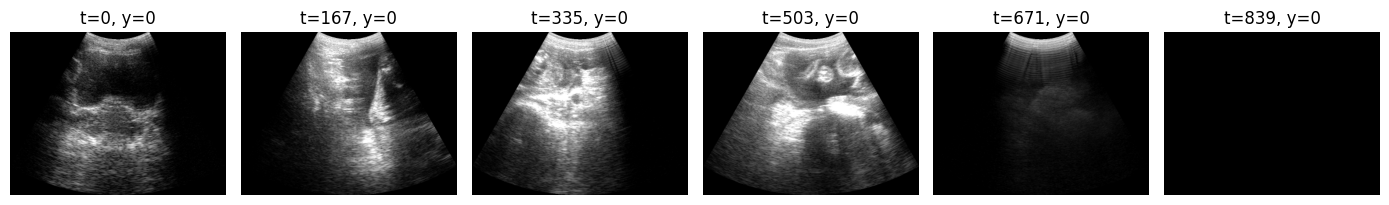

In [12]:
import numpy as np, os, random, matplotlib.pyplot as plt

npz_dir = r"D:/dataset/converted_classifier_npz_compact"
sample = random.choice([f for f in os.listdir(npz_dir) if f.endswith(".npz")])
path = os.path.join(npz_dir, sample)

data = np.load(path, allow_pickle=True)

print("File:", sample)
print("Keys:", data.files)
print("image shape:", data["image"].shape, "| dtype:", data["image"].dtype,
      "| min/max:", data["image"].min(), data["image"].max())
print("labels shape:", data["label"].shape, "| unique values:", np.unique(data["label"]))
print("pixel spacing:", data["pixel_spacing"])
print("ac reference:", data["ac_reference"])
print("uuid:", data["uuid"])

# show some frames + their labels
imgs = data["image"]
labels = data["label"]

T = imgs.shape[0]
idxs = np.linspace(0, T-1, num=min(6, T), dtype=int)

fig, axes = plt.subplots(1, len(idxs), figsize=(14,3))
for ax, i in zip(axes, idxs):
    ax.imshow(imgs[i], cmap="gray", vmin=0, vmax=255)
    ax.set_title(f"t={i}, y={labels[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


Case 032b9024-3685-4a81-a62e-813d2da3d387.npz | found 17 frames with label=1


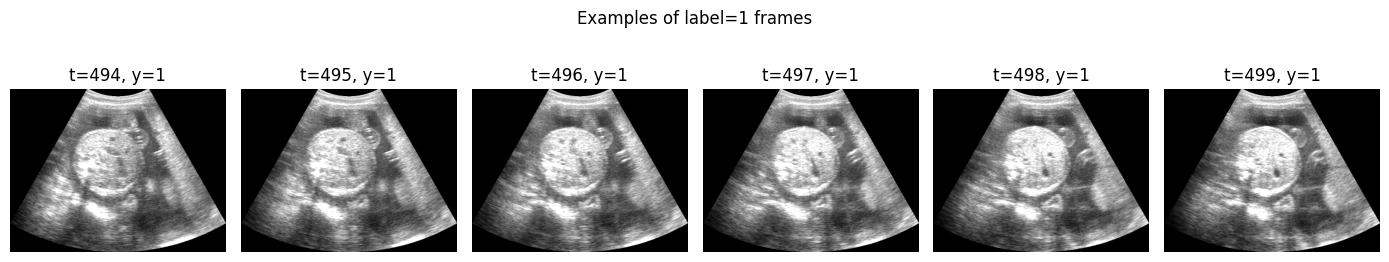

Case 0199616b-bdeb-4119-97a3-a5a3571bd641.npz | found 19 frames with label=2


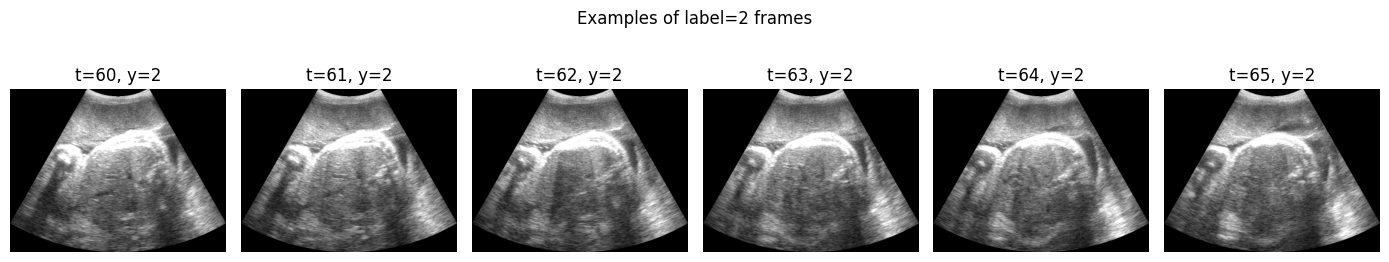

In [13]:
import numpy as np, os, matplotlib.pyplot as plt

npz_dir = r"D:/dataset/converted_classifier_npz_compact"

def find_case_with_label(label_val):
    """Return path to first .npz containing given label (1=optimal, 2=suboptimal)."""
    for f in os.listdir(npz_dir):
        if not f.endswith(".npz"): continue
        d = np.load(os.path.join(npz_dir, f), allow_pickle=True)
        if np.any(d["label"] == label_val):
            return os.path.join(npz_dir, f)
    return None

# pick one optimal and one suboptimal case
opt_path = find_case_with_label(1)
subopt_path = find_case_with_label(2)

for label_val, path in [(1,opt_path), (2,subopt_path)]:
    if path is None:
        print(f"No case found with label {label_val}")
        continue
    
    d = np.load(path, allow_pickle=True)
    imgs, labels = d["image"], d["label"]
    idxs = np.where(labels == label_val)[0]
    print(f"Case {os.path.basename(path)} | found {len(idxs)} frames with label={label_val}")

    # pick up to 6 frames
    show_idxs = idxs[:6] if len(idxs) > 6 else idxs
    fig, axes = plt.subplots(1, len(show_idxs), figsize=(14,3))
    for ax,i in zip(axes, show_idxs):
        ax.imshow(imgs[i], cmap="gray", vmin=0, vmax=255)
        ax.set_title(f"t={i}, y={labels[i]}")
        ax.axis("off")
    plt.suptitle(f"Examples of label={label_val} frames")
    plt.tight_layout()
    plt.show()


c:\Users\User\anaconda3\envs\torch310\lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)
c:\Users\User\anaconda3\envs\torch310\lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Case: 856cbf9c-8eb7-459c-b9e7-641459b393b0
T (compared): 840
SSIM (mean±sd):  1.0000 ± 0.0000
PSNR (mean±sd):  inf ± nan dB


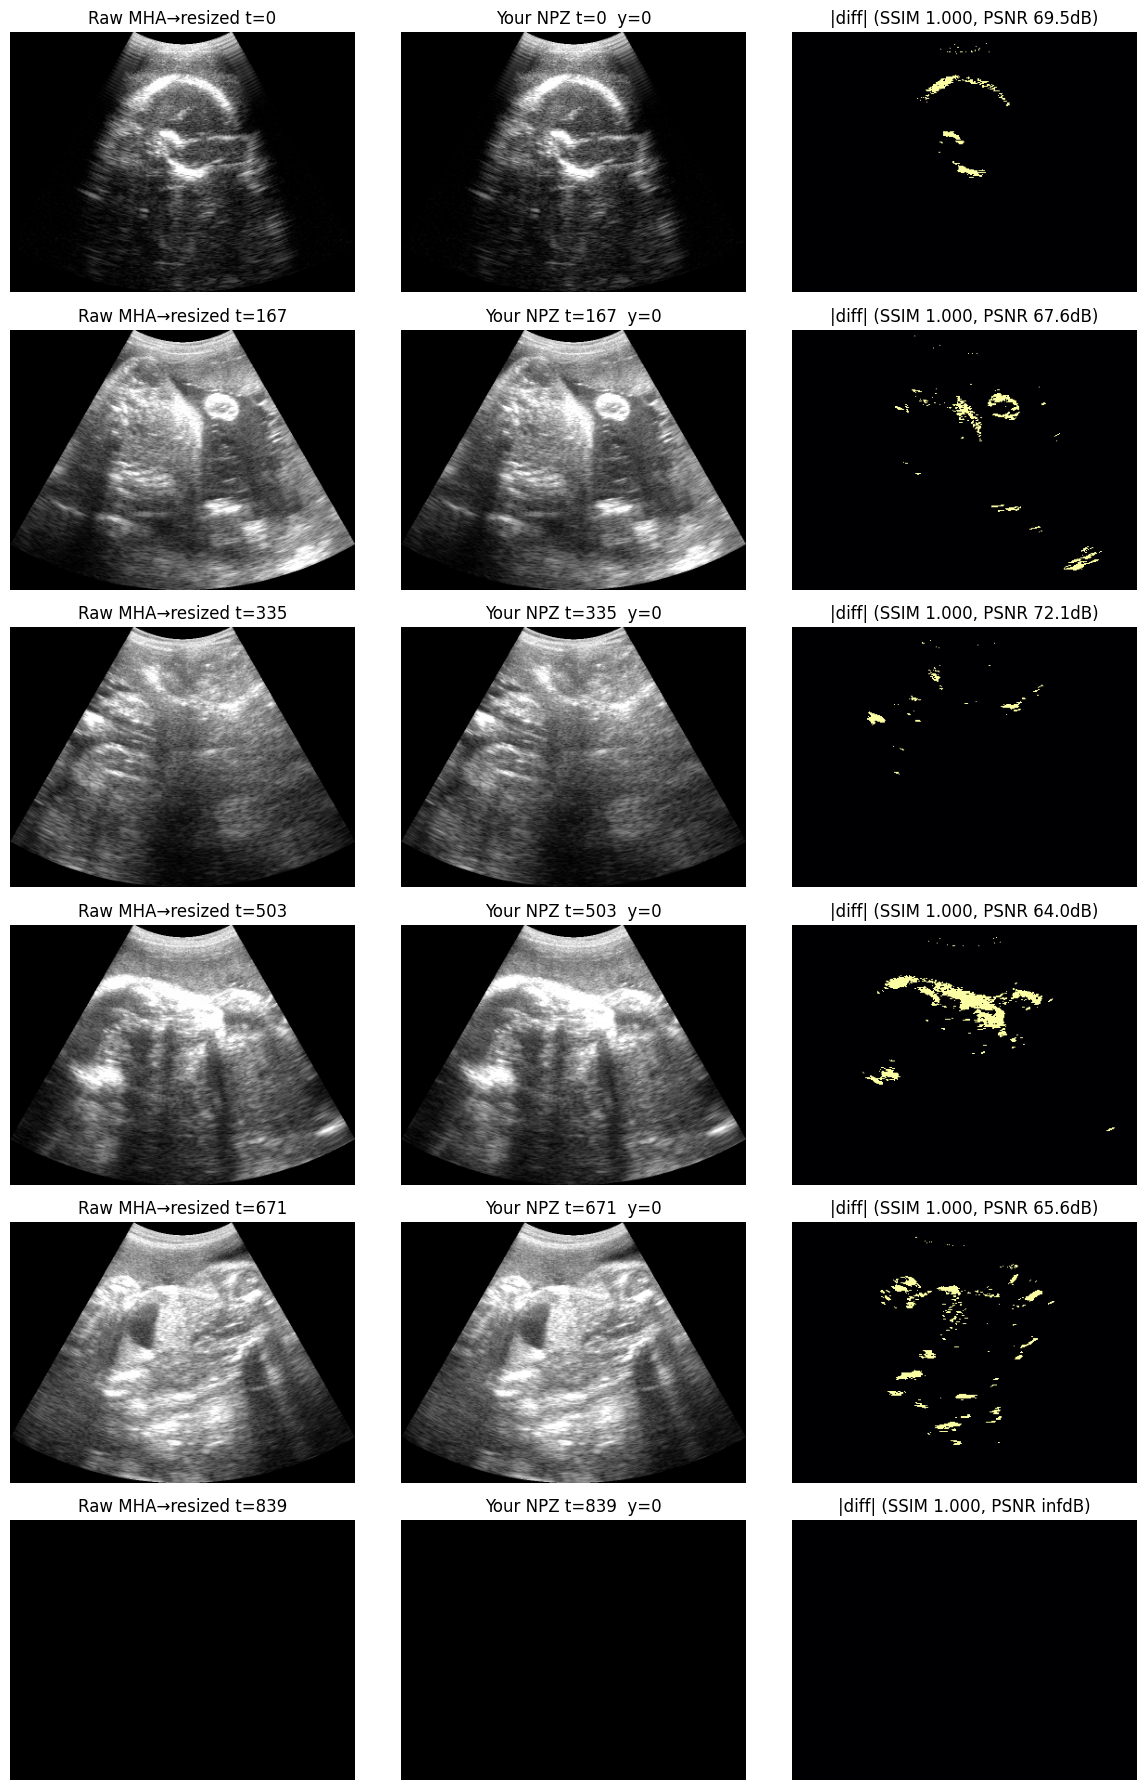

In [14]:
import os, random, numpy as np, cv2, SimpleITK as sitk, matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

# ---- set your folders ----
NPZ_DIR  = r"D:/dataset/converted_classifier_npz_compact"   # your compact npz folder
IMG_DIR  = r"D:/dataset/acouslic-ai-train-set/images/stacked_fetal_ultrasound"
MASK_DIR = r"D:/dataset/acouslic-ai-train-set/masks/stacked_fetal_abdomen"  # optional (not used here)

# ---- helper: resize a [T,H,W] stack ----
def resize_stack(arr, out_h, out_w, interp):
    return np.stack([cv2.resize(fr, (out_w, out_h), interpolation=interp) for fr in arr], axis=0)

def compare_case(case_id=None, num_frames=6, seed=0):
    rng = np.random.RandomState(seed)
    # pick a case from NPZ folder
    npz_files = [f for f in os.listdir(NPZ_DIR) if f.endswith(".npz")]
    if not npz_files:
        raise RuntimeError("No .npz files found in NPZ_DIR")
    if case_id is None:
        sample = rng.choice(npz_files)
        case_id = os.path.splitext(sample)[0]
    else:
        sample = case_id + ".npz"
        if sample not in npz_files:
            raise FileNotFoundError(f"{sample} not found in {NPZ_DIR}")

    npz_path = os.path.join(NPZ_DIR, sample)
    mha_img_path = os.path.join(IMG_DIR, case_id + ".mha")

    # --- load NPZ (your converted data) ---
    d = np.load(npz_path, allow_pickle=True)
    img_npz = d["image"]           # [T,h,w] uint8
    labels  = d["label"]           # [T] uint8 (0/1/2)
    target_h = int(d.get("target_h", img_npz.shape[1]))
    target_w = int(d.get("target_w", img_npz.shape[2]))
    # scaling percentiles used during conversion (fallback to 1/99 if absent)
    scale_lo = float(d.get("scale_lo", 1.0))
    scale_hi = float(d.get("scale_hi", 99.0))

    # --- load MHA (raw) ---
    img_mha = sitk.ReadImage(mha_img_path)
    arr_mha = sitk.GetArrayFromImage(img_mha).astype(np.float32)  # [T,H,W]

    # --- resize raw MHA to NPZ size for fair visual/metric comparison ---
    arr_mha_resz = resize_stack(arr_mha, target_h, target_w, cv2.INTER_AREA)  # anti-aliased downsample

    # --- apply the same percentile scaling the converter used ---
    lo_v, hi_v = np.percentile(arr_mha_resz, [scale_lo, scale_hi])
    arr_mha_u8 = ((np.clip(arr_mha_resz, lo_v, hi_v) - lo_v) / (hi_v - lo_v + 1e-6) * 255.0).astype(np.uint8)

    # --- align length ---
    T = min(len(img_npz), len(arr_mha_u8))
    img_npz = img_npz[:T]
    arr_mha_u8 = arr_mha_u8[:T]
    labels = labels[:T]

    # --- pick indices to visualize ---
    if T <= num_frames:
        idxs = np.arange(T)
    else:
        idxs = np.linspace(0, T-1, num_frames, dtype=int)

    # --- compute SSIM/PSNR per chosen frame ---
    ssim_list, psnr_list = [], []
    for i in idxs:
        ssim_list.append(ssim(arr_mha_u8[i], img_npz[i], data_range=255))
        psnr_list.append(psnr(arr_mha_u8[i], img_npz[i], data_range=255))

    print(f"Case: {case_id}")
    print(f"T (compared): {T}")
    print("SSIM (mean±sd):  {:.4f} ± {:.4f}".format(np.mean(ssim_list), np.std(ssim_list)))
    print("PSNR (mean±sd):  {:.2f} ± {:.2f} dB".format(np.mean(psnr_list), np.std(psnr_list)))

    # --- plot rows: [MHA-rescaled | NPZ | |diff| heatmap] ---
    cols = 3
    fig, axes = plt.subplots(len(idxs), cols, figsize=(12, 3*len(idxs)))
    if len(idxs) == 1:
        axes = np.array([axes])  # make it 2D for consistency

    for r, t in enumerate(idxs):
        diff = cv2.absdiff(arr_mha_u8[t], img_npz[t])
        # normalize diff for display
        diff_show = (diff / max(1, diff.max()) * 255).astype(np.uint8)

        axes[r,0].imshow(arr_mha_u8[t], cmap="gray", vmin=0, vmax=255)
        axes[r,0].set_title(f"Raw MHA→resized t={t}")
        axes[r,1].imshow(img_npz[t], cmap="gray", vmin=0, vmax=255)
        axes[r,1].set_title(f"Your NPZ t={t}  y={labels[t]}")
        im = axes[r,2].imshow(diff_show, cmap="inferno")
        axes[r,2].set_title(f"|diff| (SSIM {ssim_list[r]:.3f}, PSNR {psnr_list[r]:.1f}dB)")
        for c in range(cols):
            axes[r,c].axis("off")

    plt.tight_layout()
    plt.show()

# ---- run it ----
compare_case(case_id=None, num_frames=6, seed=0)  # set case_id="uuid" to test a specific case
